# GPU割当・ドライブのマウント

In [1]:
# GPU の確認
!nvidia-smi
# Google Drive のマウント（Google Drive のファイルを読み書きできるようにする）
from google.colab import drive
drive.mount('/content/drive')

Wed Oct 14 01:32:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# 事前に upload したファイルを Google Drive からコピー

data_path = "/content/drive/My Drive/Colaboratory/jts_7/"

import shutil
import os
to_data_dir = "data/"
os.makedirs(to_data_dir, exist_ok=True)

fname_list = [
    "daytona.zip", 
    "gmtmaster.zip", 
    "train_kfold_00.csv", 
    "test_kfold_00.csv", 
    "train_kfold_01.csv", 
    "test_kfold_01.csv"
]
for fname in fname_list:
    shutil.copy(data_path + fname, to_data_dir + fname)

In [4]:
# 事前に upload した zipファイルを解凍
%cd data
!unzip -qq -n daytona.zip
!unzip -qq -n gmtmaster.zip
!ls
%cd ../

/content/data
daytona      gmtmaster	    test_kfold_00.csv  train_kfold_00.csv
daytona.zip  gmtmaster.zip  test_kfold_01.csv  train_kfold_01.csv
/content


# 学習コードの実行

In [6]:
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [7]:
# 各種設定
BATCH_SIZE = 50
MAX_EPOCH = 25
IMAGE_SIZE = 224
# シード値の固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# GPU利用設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cuda


In [8]:
# 自作のデータセットの処理
class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None, loader=default_loader):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir  # 画像が入っているディレクトリのパス
        self.loader = loader
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    # dataloaderで読み込むときの処理
    def __getitem__(self, idx):
        # filename取得
        img_name = self.df.iloc[idx, 0]
        # 画像のパス設定
        img_path = os.path.join(self.root_dir, img_name)
        # 画像読み込み
        image = self.loader(img_path)
        # user_id = self.df.iloc[idx, 2]

        label = self.df.iloc[idx, 1]

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label, img_path


# データの前処理を定義
transform = transforms.Compose(
    [
        # 画像のリサイズ
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # tensorに変換
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
)

# 訓練用のデータ前処理を定義
train_transform = transforms.Compose(
    [
        # 画像のリサイズ
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # ここにData augmentation処理を記述する
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.9, contrast=0.9),
        # tensorに変換
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
)




In [9]:
K = 2
train_dataset_list = []
test_dataset_list = []
train_loader_list = []
valid_loader_list = []
test_loader_list = []
model_list = []

for i in range(K):
    # 訓練データを取得
    train_dataset = MyDataset(
        csv_file="./data/train_kfold_{:02}.csv".format(i),
        root_dir='./',  # 画像を保存したディレクトリ(適宜書き換えて)
        transform=transform,
    )
    # 訓練データの一部を検証データとして使用
    num_train = len(train_dataset)
    num_valid = int(num_train * 0.2)
    train_dataset, valid_dataset = torch.utils.data.random_split(
        train_dataset,
        [num_train - num_valid, num_valid],
    )
    # DataLoaderを作成

    # 訓練時のtransformを設定
    train_dataset.dataset.transform = train_transform

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    # テストデータも同様
    test_dataset = MyDataset(
        "./data/test_kfold_{:02}.csv".format(i),
        root_dir='./',
        transform=transform,
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # ニューラルネットワーク
    model = models.resnet18(pretrained=True)
    # print(model)
    model.fc = nn.Linear(512, 2)

    model = model.to(device)

    train_dataset_list.append(train_dataset)
    test_dataset_list.append(test_dataset)
    valid_loader_list.append(valid_loader)
    train_loader_list.append(train_loader)
    test_loader_list.append(test_loader)
    model_list.append(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


processing train data ...
epoch	train loss	valid loss	valid accuracy	processed time
0	0.435464	0.303155	0.875000	12.162963
1	0.116734	0.202906	0.943182	24.493228
2	0.069690	0.134988	0.965909	36.817669
3	0.065052	0.088325	0.965909	49.065048
4	0.023559	0.149214	0.965909	61.032130
5	0.018096	0.074276	0.977273	73.053654
6	0.018830	0.038542	0.977273	85.117471
7	0.246445	0.081715	0.977273	96.956322
8	0.026093	0.166660	0.920455	108.686754
9	0.230267	0.160929	0.954545	120.444189
10	0.104136	0.098302	0.954545	132.121633
11	0.038300	0.122779	0.965909	143.869628
12	0.044225	0.090387	0.965909	155.516307
13	0.171558	0.114870	0.977273	167.294275
14	0.021578	0.126937	0.988636	178.965286
15	0.045551	0.126093	0.988636	190.975323
16	0.034282	0.148086	0.954545	202.698096
17	0.067662	0.146225	0.977273	214.307653
18	0.061206	0.108519	0.943182	226.064867
19	0.038574	0.103817	0.965909	237.716760
20	0.168577	0.099267	0.954545	249.397048
21	0.025616	0.123745	0.977273	261.133886
22	0.048263	0.152213	0.954545	27

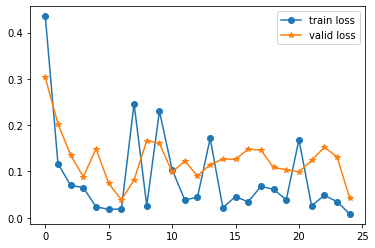

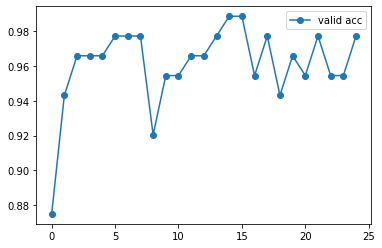

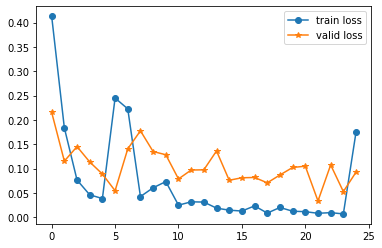

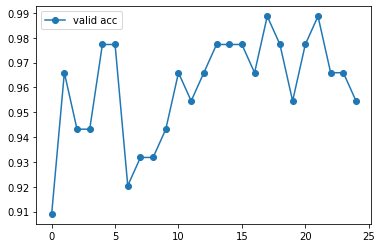

In [10]:
v_acc_list = []
t_acc_list = []
v_accuracy_list = []
cm_list = []
test_accuracy_list = []
for i in range(K):
    # 損失関数
    loss_function = nn.CrossEntropyLoss()
    # 勾配降下法を行うoptimizer
    optimizer = optim.Adam(model_list[i].parameters(), lr=0.0001)

    start = time.time()
    print('processing train data ...')

    v_acc = []
    t_acc = []
    best_v_acc = 0
    v_accuracy = []
    print("epoch\ttrain loss\tvalid loss\tvalid accuracy\tprocessed time")
    for epoch in range(MAX_EPOCH):
        model_list[i].train()
        train_loss_list = []
        # DataLoaderをfor文で回すと入力と正解ラベルが得られる
        for x, label, img_path in train_loader_list[i]:
            x = x.to(device)
            label = label.to(device)
            # 勾配を0に初期化
            optimizer.zero_grad()
            # 順伝播
            output = model_list[i](x)
            # 誤差の計算
            loss = loss_function(output, label)
            # 誤差逆伝播
            loss.backward()
            # パラメータ更新
            optimizer.step()
            # ミニバッチの訓練誤差をlistに追加
            train_loss_list.append(loss.item())
        # 各ミニバッチでの訓練誤差の平均を取り，本エポックでの訓練誤差とする
        train_loss_mean = np.mean(train_loss_list)

        # 検証データでも同様に誤差を計算
        # モデルを評価する時は model.eval() とする
        model_list[0].eval()
        valid_loss_list = []
        valid_correct, valid_total = 0, 0
        for x, label, img_path in valid_loader_list[i]:
            x = x.to(device)
            label = label.to(device)

            output = model_list[i](x)
            loss = loss_function(output, label)
            valid_loss_list.append(loss.item())

            pred = output.argmax(dim=1, keepdim=True)
            # 正解ラベルと比較，一致している数を加算
            valid_correct += pred.eq(label.view_as(pred)).sum().item()
            # 正解率(accuracy)を出すためにテストデータの数も加算
            valid_total += label.size()[0]

        valid_loss_mean = np.mean(valid_loss_list)

        valid_accuracy = valid_correct / valid_total

        print("{0}\t{1:.6f}\t{2:.6f}\t{3:.6f}\t{4:.6f}".format(epoch, train_loss_mean, valid_loss_mean, valid_accuracy, time.time() - start))
        t_acc.append(train_loss_mean)
        v_acc.append(valid_loss_mean)
        v_accuracy.append(valid_accuracy)
        # モデル保存
        if valid_accuracy > best_v_acc:
            best_v_acc = valid_accuracy
            model_dir = "./model/"
            os.makedirs(model_dir, exist_ok=True)
            save_path = model_dir + "cnn{:02}.pt".format(i)
            torch.save(model_list[i].state_dict(), save_path)

    # 可視化コード
    fig, ax = plt.subplots(1,1)
    ax.plot(t_acc, label="train loss", marker="o")
    ax.plot(v_acc, label="valid loss", marker="*")
    ax.legend()
    plt.savefig("losscurve.png", bbox_inches="tight")

    fig, ax = plt.subplots(1,1)
    ax.plot(v_accuracy, label="valid acc", marker="o")
    ax.legend()
    plt.savefig("acccurve.png", bbox_inches="tight")

    # モデル読込
    model_list[i].load_state_dict(torch.load("./model/cnn{:02}.pt".format(i)))

    # モデルの評価(テストデータを使用)
    print('processing test data ...')
    model_list[i].eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    for n, (x, label, img_path) in enumerate(test_loader_list[i]):
        x = x.to(device)
        label = label.to(device)
        output = model_list[i](x)
        loss = loss_function(output, label)
        # 出力値が最大のインデックスを取得
        pred = output.argmax(dim=1, keepdim=True)

        preds = pred if n == 0 else torch.cat([preds, pred])
        labels = label if n == 0 else torch.cat([labels, label])

        # 正解ラベルと比較，一致している数を加算
        test_correct += pred.eq(label.view_as(pred)).sum().item()
        # 正解率(accuracy)を出すためにテストデータの数も加算
        test_total += label.size()[0]

    test_accuracy = test_correct / test_total
    print("Test accuracy :", test_accuracy)

    cm = confusion_matrix(labels.cpu(), preds.cpu())

    v_acc_list.append(v_acc)
    t_acc_list.append(t_acc)
    v_accuracy_list.append(v_accuracy)
    test_accuracy_list.append(test_accuracy)
    cm_list.append(cm)



# **分析コードを書きましょう**

## テストデータに対するAccuracyの平均値を算出してください

## 各データ分割におけるテストデータの混同行列を表示してください

## 誤認識があった画像パスを出力してください

In [ ]:
for i in range(K):
    for n, (x, label, img_path) in enumerate(test_loader_list[i]):
        x = x.to(device)
        label = label.to(device)
        output = model_list[i](x)
        # 出力値が最大のインデックスを取得
        pred = output.argmax(dim=1, keepdim=True)
        
        # ここに処理を記述